In [3]:
import os, sys
sys.path.append('.')

from dataclasses import dataclass
from pathlib import Path

import draccus
import torch
import torch.distributed as dist
import tqdm
import wandb
from accelerate import PartialState
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from transformers.modeling_outputs import CausalLMOutputWithPast
from torch.optim.lr_scheduler import StepLR
from transformers import get_linear_schedule_with_warmup

from vla.base_prompter import PurePromptBuilder
from vla.utils import PaddedCollatorForPosePrediction, runningLoss
from vla.action_tokenizer import RLbenchPoseTokenizer
from vla.dataset import RLbenchCotDataset
import numpy as np
import torch.nn.functional as F

import numpy as np
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import ArmActionMode, JointVelocity, JointPosition, EndEffectorPoseViaPlanning, EndEffectorPoseViaIK


from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.observation_config import ObservationConfig, CameraConfig
# from rlbench.tasks.pick_described_object import PickDescribedObject
from rlbench.tasks import PutGroceriesInCupboard, PickAndLift, StackBlocks, PlaceHangerOnRack, PickDescribedObject, TakeLidOffSaucepan, SetTheTable
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
from PIL import Image


In [4]:
base_model_path = "/media/lawrence/Work/checkpoints/ecot-openvla-7b-bridge"
adapter_path = "adapter-tmp/weighted_loss_cot+pick_described_object+e2+b20+lr-5e-05+lora-r16+dropout-0.0+q-4bit"
# save_path = "/media/lawrence/Work/checkpoints/vla-rl-ecot"

In [5]:
dataset_statistics: tuple = (np.array([-0.27499999, -0.65500004,  0.75199986, -np.pi, -np.pi, -np.pi,  0. ]), np.array([0.77499999, 0.65500004, 1.75199986, np.pi, np.pi, np.pi, 1.])) # Min-Max normalization statistics


In [6]:
processor = AutoProcessor.from_pretrained(base_model_path, trust_remote_code=True)
action_tokenizer = RLbenchPoseTokenizer(processor.tokenizer,dataset_statistics)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
quantization_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type="nf4", #llm_int8_skip_modules = ['projector'],
        )
vla = AutoModelForVision2Seq.from_pretrained(
        base_model_path,
        torch_dtype=torch.bfloat16,
        attn_implementation="sdpa",
        quantization_config=quantization_config,
        low_cpu_mem_usage=True,
        trust_remote_code=True,
        device_map = "cuda"
    )
# vla.tie_weights()

Loading checkpoint shards: 100%|██████████| 3/3 [00:34<00:00, 11.39s/it]


In [ ]:
vla.load_adapter(adapter_path,'vla')

In [ ]:
class Agent(object):
    def __init__(self, vla, processor, action_tokenizer):
        self.vla = vla
        self.processor = processor
        self.action_tokenizer = action_tokenizer

    def get_openvla_prompt(self, instruction: str):
        SYSTEM_PROMPT = "You are an assistant helping to control a robotic manipulator. The robot performs tasks by following a series of steps to interact with objects in its environment. The environment includes items like soup cans and baskets, and the robot uses a gripper to pick up and move these items.\n\nInstructions format:\n- 'USER': Describes the task to be performed.\n- 'ASSISTANT': Provides a detailed step-by-step plan for the robot to execute the task.\n\nThe 'ASSISTANT' response includes:\n1. A logical step-by-step plan for the task.\n2. The current positions of relevant objects and the gripper.\n3. The current state of the gripper (whether it has grasped the object or not).\n4. The next key pose of the gripper to achieve the task.\n\nExample:\n\nUSER: What action should the robot take to pick up the soup and place it in the basket?\nASSISTANT: Let's think step by step. The plan is to move the gripper to the soup and pick it up, then move over the basket, and then place the soup in the basket. The soup is located at <object>ĉ‖호 </object>. The basket is located at <target>Ζ‖ご </target>. The gripper pose is <gripper>阳‖素군雅导弘 </gripper>. The gripper hasn't grasped the soup. So the current step is to move the gripper to the soup and pick it up. The next key pose of the gripper is <action>机‖素秀麻방弘 </action>. \n <current conversation>"
        return f"{SYSTEM_PROMPT} USER: What action should the robot take to {instruction.lower()}? ASSISTANT: Let's think step by step,"

    def get_instruct_prompt(self, instruction: str):
        prompt = f"In: You are an assistant helping to control a robotic manipulator. The robot performs tasks by following a series of steps to interact with objects in its environment. What the next key pose of gripper should the robot take to {instruction}? Out: Let's think step by step,"
        return prompt

    def act(self, obs, instr):
        prompt = self.get_instruct_prompt(instr)
        image = Image.fromarray(obs.front_rgb)
        
        inputs = self.processor(prompt, image).to(self.vla.device, dtype=torch.bfloat16)
        output_dict = self.vla.generate(**inputs, max_new_tokens = 200, output_scores = True, return_dict_in_generate=True, do_sample = False, temperature=1, top_k=1, top_p=0.9)
        action_mask, gripper_mask, object_mask, target_mask = self.action_tokenizer.get_mask(output_dict.sequences)
        print(self.processor.tokenizer.decode(output_dict.sequences[0]))
        output_logits = torch.stack(output_dict.scores, dim = 1)
        action_logits = output_logits[action_mask[:,-output_logits.size(1):]][:,self.action_tokenizer.action_token_begin_idx:self.processor.tokenizer.vocab_size].view(1,-1,self.action_tokenizer.n_bins)
        gripper_logits = output_logits[gripper_mask[:,-output_logits.size(1):]][:,self.action_tokenizer.action_token_begin_idx:self.processor.tokenizer.vocab_size].view(1,-1,self.action_tokenizer.n_bins)
        object_logits = output_logits[object_mask[:,-output_logits.size(1):]][:,self.action_tokenizer.action_token_begin_idx:self.processor.tokenizer.vocab_size].view(1,-1,self.action_tokenizer.n_bins)
        target_logits = output_logits[target_mask[:,-output_logits.size(1):]][:,self.action_tokenizer.action_token_begin_idx:self.processor.tokenizer.vocab_size].view(1,-1,self.action_tokenizer.n_bins)
        # action = self.action_tokenizer.sample(action_logits.cpu())
        action = self.action_tokenizer.decode(action_logits).cpu().numpy().squeeze(0)
        return action
        

In [ ]:
agent = Agent(vla, processor, action_tokenizer)

In [ ]:
camera = CameraConfig(image_size=(224, 224), depth=False, point_cloud=False, mask=False)
obs_config = ObservationConfig(left_shoulder_camera=camera, right_shoulder_camera=camera, front_camera=camera, overhead_camera=camera)

env = Environment(
    action_mode=MoveArmThenGripper(
        arm_action_mode=EndEffectorPoseViaPlanning(absolute_mode=True, collision_checking=False), gripper_action_mode=Discrete()),
    obs_config=obs_config,
    headless=False)
env.launch()

In [ ]:
task = env.get_task(PickDescribedObject)
lower_bound = np.array([task._scene._workspace_minx, task._scene._workspace_miny, task._scene._workspace_minz])
upper_bound = np.array([task._scene._workspace_maxx, task._scene._workspace_maxy, task._scene._workspace_maxz])
training_steps = 1000
episode_length = 100
obs = None
while 1:
    try:
        for i in range(training_steps):
            if i % episode_length == 0:
                print('Reset Episode')
                descriptions, obs = task.reset()
                plt.imshow(obs.front_rgb)
                print(descriptions[1])            
                pos = np.random.uniform(lower_bound, upper_bound)
                rot = np.random.uniform(-np.pi, np.pi, 3)
                joint_position = task._scene.robot.arm.solve_ik_via_sampling(position=pos, euler=rot)
                task._scene.robot.arm.set_joint_positions(joint_position[0], disable_dynamics=True)
            action = agent.act(obs,descriptions[1])
            action_rotation = R.from_euler('xyz', action[3:6])
            action_quaternion = action_rotation.as_quat()
            # print(delta_quaternion)  # returns (qx, qy, qz, qw)
            action = np.concatenate([action[0:3], action_quaternion, action[-1:]])
            print(action)
            obs, reward, terminate = task.step(action)
            print(reward)
    except Exception as e:
        print(e)


Reset Episode
pick up the chocolate jello and place in the basket
Could not find a valid joint configuration for desired end effector pose.
Reset Episode
pick up the chocolate jello and place in the basket
Could not find a valid joint configuration for desired end effector pose.
Reset Episode
pick up the chocolate jello and place in the basket
Could not find a valid joint configuration for desired end effector pose.
Reset Episode
pick up the chocolate jello and place in the basket


/home/lawrence/anaconda3/envs/VLA-RL/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/lawrence/anaconda3/envs/VLA-RL/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:509: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


<s> In: You are an assistant helping to control a robotic manipulator. The robot performs tasks by following a series of steps to interact with objects in its environment. What the next key pose of gripper should the robot take to pick up the chocolate jello and place in the basket? Out: Let's think step by step, First, move the gripper to the chocolate jello and pick it up. Next, move over the basket, and finally, place the chocolate jello in the basket. The chocolate jello is located at <object>Ġ瀬합ữrivialŸ</s>
Expected `angles` to be at most 2-dimensional with width equal to number of axes specified, got (0,) for shape
Reset Episode
pick up the chocolate jello and place in the basket
<s> In: You are an assistant helping to control a robotic manipulator. The robot performs tasks by following a series of steps to interact with objects in its environment. What the next key pose of gripper should the robot take to pick up the chocolate jello and place in the basket? Out: Let's think step

In [ ]:
env.shutdown()

[CoppeliaSim:loadinfo]   done.


In [42]:
test_data_path: Path = Path(f"./datasets/pick_described_object/train_data2.pt")
testset = RLbenchCotDataset(
    test_data_path,
    action_tokenizer,
    processor.tokenizer,
    image_transform=processor.image_processor.apply_transform,
    prompt_builder_fn=PurePromptBuilder,
)
collator = PaddedCollatorForPosePrediction(
    processor.tokenizer.model_max_length, processor.tokenizer.pad_token_id, padding_side="right"
)
test_dataloader = DataLoader(
    testset,
    batch_size=2,
    sampler=None,
    collate_fn=collator,
    num_workers=1,  # Important =>> Set to 0 if using RLDS; TFDS rolls its own parallelism!
)


In [43]:
data_dict = torch.load(test_data_path)

In [44]:
data_dict.keys()

dict_keys(['items', 'imgs', 'instructions', 'cots', 'target_item_poses', 'gripper_poses', 'basket_positions', 'actions'])

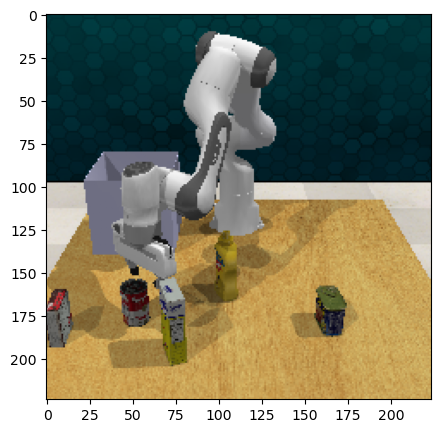

tensor([ 0.2603, -0.2599,  0.8494,  3.1096,  0.0348,  2.3743,  0.0000],
       dtype=torch.float64)
tensor([ 0.2481, -0.2270,  0.8649,  3.1072,  0.0409,  2.3846,  1.0000],
       dtype=torch.float64)


In [54]:
test = next(iter(test_dataloader))
# plt.imshow(test["imgs"][0].permute(1, 2, 0))
figure = plt.figure(figsize=(5, 5))
plt.imshow((test['pixel_values'][0].squeeze(0).permute(1,2,0) + 1)/2)
plt.show()
print(test['actions'][0])
print(test['gripper_poses'][0])

In [ ]:
(test['input_ids'] == 32002).cumsum(dim=1)

tensor([[0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2]])

In [ ]:
((test['input_ids'] == 32008).cumsum(dim=1)==2).to(torch.int).argmax(dim=1)

tensor([446, 446])

In [ ]:
action_tokenizer.get_mask(test['input_ids'])[0]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [ ]:
processor.tokenizer.decode(test['input_ids'][0])

"<s> You are an assistant helping to control a robotic manipulator. The robot performs tasks by following a series of steps to interact with objects in its environment. The environment includes items like soup cans and baskets, and the robot uses a gripper to pick up and move these items.\n\nInstructions format:\n- 'USER': Describes the task to be performed.\n- 'ASSISTANT': Provides a detailed step-by-step plan for the robot to execute the task.\n\nThe 'ASSISTANT' response includes:\n1. A logical step-by-step plan for the task.\n2. The current positions of relevant objects and the gripper.\n3. The current state of the gripper (whether it has grasped the object or not).\n4. The next key pose of the gripper to achieve the task.\n\nExample:\n\nUSER: What action should the robot take to pick up the soup and place it in the basket?\nASSISTANT: Let's think step by step. The plan is to move the gripper to the soup and pick it up, then move over the basket, and then place the soup in the baske

In [ ]:
instr

'pick up the chocolate jello and place in the basket'